In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Dataset Paths
train_dir = "/kaggle/input/1000-videos-split/1000_videos/train"
val_dir = "/kaggle/input/1000-videos-split/1000_videos/validation"
test_dir ='/kaggle/input/1000-videos-split/1000_videos/test'

# Image Preprocessing
img_size = (299, 299)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

# Load Xception Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
epochs = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1)

# Save Model
model.save("xception_deepfake_model.h5")

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 11633 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Epoch 1/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 351s 859ms/step - accuracy: 0.7060 - loss: 0.5156 - val_accuracy: 0.9004 - val_loss: 0.2813 - learning_rate: 1.0000e-04
Epoch 2/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 303s 819ms/step - accuracy: 0.9303 - loss: 0.1739 - val_accuracy: 0.8338 - val_loss: 0.5794 - learning_rate: 1.0000e-04
Epoch 3/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 304s 822ms/step - accuracy: 0.9522 - loss: 0.1177 - val_accuracy: 0.9192 - val_loss: 0.2694 - learning_rate: 1.0000e-04
Epoch 4/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 303s 819ms/step - accuracy: 0.9667 - loss: 0.0793 - val_accuracy: 0.9296 - val_loss: 0.2322 - learning_rate: 1.0000e-04
Epoch 5/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 304s 822ms/step - accuracy: 0.9684 - loss: 0.0790 - val_accuracy: 0.9225 - val_loss: 0.2158 - learning_rate: 1.0000e-04
Epoch 6/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 303s 819ms/step - accuracy: 0.972

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import cv2

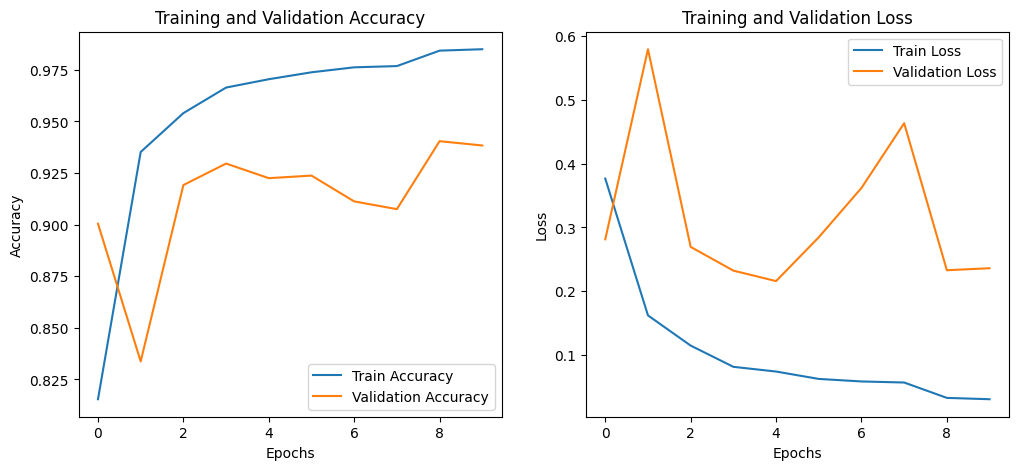

In [4]:
# Plot Training Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

plot_training_history(history)

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step
Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.92      0.93      1200
        Fake       0.92      0.94      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



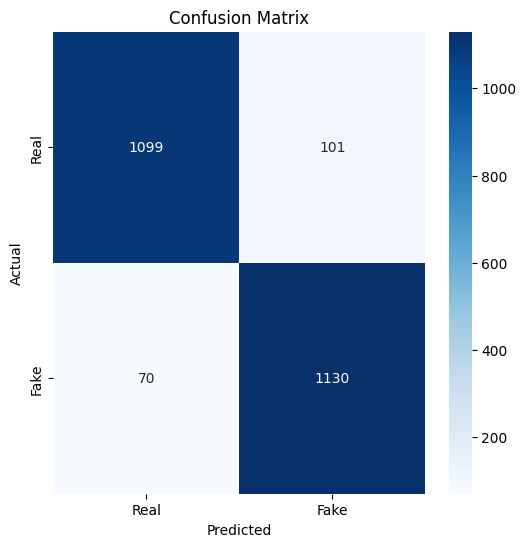

In [6]:
# Classification Report & Confusion Matrix
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/kaggle/input/videoframe/tensorflow2/default/1/xception_deepfake_model.h5")

# Set image size
img_size = (299, 299)

# Function to detect deepfake in video frames
def predict_video_frames(video_path, model, frame_interval=10):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            frame_resized = cv2.resize(frame, img_size)
            frame_normalized = frame_resized / 255.0
            frame_expanded = np.expand_dims(frame_normalized, axis=0)

            # Predict using the model
            prediction = model.predict(frame_expanded)[0][0]
            label = "Fake" if prediction > 0.5 else "Real"
            color = (0, 0, 255) if label == "Fake" else (0, 255, 0)  # Red for Fake, Green for Real

            # Draw label on frame
            cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

            # Convert frame to RGB for display
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        frame_count += 1
    
    cap.release()
    cv2.destroyAllWindows()

# Example Usage
#/kaggle/input/deep-fake-detection-dfd-entire-original-dataset
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02_meeting_serious_YVGY8LOK.mp4"
predict_video_frames(video_path, model)

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Load the trained model
model = load_model("/kaggle/working/xception_deepfake_model.h5")

# Set image size
img_size = (299, 299)

# Function to compute Grad-CAM heatmap
def compute_gradcam(model, img_array, layer_name="block14_sepconv2_act"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # For binary classification (Fake = 1)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Function to apply Grad-CAM on video frames
def predict_video_frames(video_path, model, frame_interval=10):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_resized = cv2.resize(frame, img_size)
            frame_normalized = frame_resized / 255.0
            frame_expanded = np.expand_dims(frame_normalized, axis=0)

            # Predict Fake or Real
            prediction = model.predict(frame_expanded)[0][0]
            label = "Fake" if prediction > 0.5 else "Real"
            color = (0, 0, 255) if label == "Fake" else (0, 255, 0)

            # If Fake, apply Grad-CAM
            if label == "Fake":
                heatmap = compute_gradcam(model, frame_expanded)
                heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

                # Apply colormap & overlay
                heatmap = np.uint8(255 * heatmap)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                overlayed = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

                # Convert to grayscale & detect contours
                gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
                _, thresh = cv2.threshold(gray_heatmap, 100, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                # Draw contours on the frame
                cv2.drawContours(overlayed, contours, -1, (0, 0, 255), 2)
                frame = overlayed

            # Draw label
            cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

            # Convert frame to RGB for display
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

# Example Usage
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02_walking_down_indoor_hall_disgust_YVGY8LOK.mp4"
predict_video_frames(video_path, model)